In [1]:
# We compare pairwise similarity performance on `spectra_file`
# We can use pickled version for much faster loading times
spectra_file = 'ALL_GNPS.mgf'
# spectra_file = "MASSBANK.mgf"  # Smaller set for faster runs

# How many pairs to process and compare from spectra_file
n_spectra = 1e+5

# min tolerance
min_tolerance = 1e-3

# max tolerance
# max tolerance at .30 > causes an OOM
max_tolerance = .30

# Max evals (with LOGSCALE!) between min and max
num_evals = 15

# max number of peaks to retain in any spectra - larger numbers are marginally more accurate, but much slower
max_peaks = 1024

# optimal batch size is hardware-dependent, but usually the best number is the largest the hardware can handle (without an OOM error)
batch_size = 4096

# Hardware matters! These results are only repeatable using this GPU (shown as an output)
! nvidia-smi -L
! echo Number of CPU cores $(nproc)

GPU 0: NVIDIA GeForce RTX 4090 (UUID: GPU-ff155de2-7a01-2f4a-25c9-7393317fb5bf)
Number of CPU cores 128


In [2]:
! pip uninstall cudams -q -y
! pip install -q --upgrade git+https://github.com/tornikeo/cosine-similarity@main

In [3]:
from cudams.utils import argbatch, Timer, use_style
from pathlib import Path
from tqdm import tqdm
from numba import cuda
import numpy as np
import torch
import matplotlib.pyplot as plt
from cudams.utils import download
from joblib import Parallel, delayed
from matchms.filtering import default_filters, normalize_intensities, reduce_to_number_of_peaks
from matchms.importing import load_from_mgf
from cudams.utils import mute_stdout
from collections import defaultdict
from matchms import calculate_scores
from matchms.similarity import CosineGreedy
from cudams.similarity import CudaCosineGreedy
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib

np.random.seed(42)
use_style()
assert cuda.is_available()

/opt/conda/lib/python3.10/site-packages/sparsestack/StackedSparseArray.py:4: DeprecationWarning: Please use `get_index_dtype` from the `scipy.sparse` namespace, the `scipy.sparse.sputils` namespace is deprecated.
  from scipy.sparse.sputils import get_index_dtype


In [4]:
def parse_spectrum(spectrum):
    spectrum = default_filters(spectrum)
    spectrum = normalize_intensities(spectrum)
    spectrum = reduce_to_number_of_peaks(spectrum, n_max=max_peaks) # NOTICE! We cut off smaller peaks, after the largest `max_peaks` - this is required for the GPU
    return spectrum

spectra = []
for i, sp in enumerate(load_from_mgf(download(spectra_file))):
    spectra.append(sp)
    if i > n_spectra: # NOTICE! We don't process all of ALL_GNPS to save time - it takes around 30 mins on this machine.
        break
spectra = Parallel(-1)(
    delayed(parse_spectrum)(spe) for spe in spectra
)
spectra = [sp for sp in spectra if sp is not None]

/opt/conda/lib/python3.10/site-packages/cudams/utils.py:266: UserWarning: As of 2024, ALL_GNPS.mgf is a large file (1.76GB) make sure the machine can handle this
  warnings.warn(


2024-03-12 14:38:02,111:WARNING:matchms:correct_charge:Changed sign of given charge: -1 to match positive ionmode
2024-03-12 14:38:02,112:WARNING:matchms:correct_charge:Changed sign of given charge: -1 to match positive ionmode
2024-03-12 14:38:02,267:WARNING:matchms:correct_charge:Changed sign of given charge: -1 to match positive ionmode
2024-03-12 14:38:03,887:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Fe-2H]
2024-03-12 14:38:03,888:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Fe-2H]
2024-03-12 14:38:03,889:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Fe-2H]
2024-03-12 14:38:03,897:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Fe-2H]
2024-03-12 14:38:03,898:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Fe-2H]
2024-03-12 14:38:03,899:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Fe-2H

In [5]:
tolerances = np.logspace(
    np.log10(min_tolerance),
    np.log10(max_tolerance), 
    num=num_evals
)
np.random.seed(42)

jobs = []
for tolerance in tolerances:
    def loop(tolerance):
        references = np.random.choice(
            spectra, 
            size=int(n_spectra**.5), 
            replace=False, # Just like BLINK, we randomly select without replacement.
        )
        
        queries = np.random.choice(
            spectra,
            size=int(n_spectra**.5),
            replace=False,
        )
        tolerance = float(tolerance) # one of numba's many quirks
        kernel = CosineGreedy(
            tolerance=tolerance
        )
        scores = kernel.matrix(references, queries)
        
        kernel = CudaCosineGreedy(
            tolerance=tolerance,
            batch_size=batch_size,
            verbose=True,
        )
        scores_cu = kernel.matrix(references, queries)
        return scores, scores_cu
    jobs.append(delayed(loop)(tolerance))
data = Parallel(-1)(jobs)

100%|██████████| 1/1 [00:06<00:00,  6.09s/it]


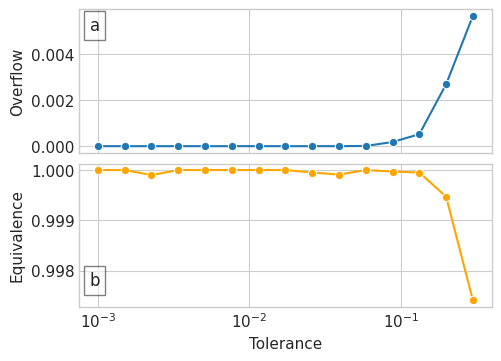

In [6]:
ov_means = []
iseq_means = []
for tolerance, (scores, scores_cu) in zip(tolerances, data):
    a = scores['score'].ravel()
    ov = scores_cu['overflow'].ravel() == 1
    b = scores_cu['score'].ravel()
    iseq = np.isclose(a,b,atol=.001)
    
    ov_means.append(ov.mean())
    iseq_means.append(iseq.mean())

fig, axs = plt.subplot_mosaic(
    [['a'], ['b']], 
    layout='constrained',
    sharex=True,
)

ax = axs['a']
sns.lineplot(x=tolerances, 
             y=ov_means,
             marker='o',
             ax=ax)

ax.text(.05, 0.95, 'a', transform=ax.transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.5))
ax.set_ylabel("Overflow")

ax = axs['b']
sns.lineplot(x=tolerances,
             y=iseq_means, 
             marker='o',
             color='orange',
             ax=ax)
# thresh_idx = np.searchsorted(iseq_means, .999)
ax.set_ylabel(r"Equivalence")

ax.set_xscale('log')
ax.set_xlabel("Tolerance")
ax.text(.05, 0.25, 'b', transform=ax.transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.5))

plt.show()